### 0. Library

In [ ]:
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import shutil
import random
from random import shuffle

from PIL import Image
from pycocotools.coco import COCO

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa

### 1. Data

In [ ]:
# 데이터셋 다운로드 및 압축 해제
!wget -nc http://images.cocodataset.org/zips/train2017.zip
!unzip -o -q /content/train2017.zip

!wget -nc http://images.cocodataset.org/zips/val2017.zip
!unzip -o -q /content/val2017.zip

!wget -nc http://images.cocodataset.org/zips/test2017.zip
!unzip -o -q /content/test2017.zip

# 주석 다운로드 및 압축 해제
!wget -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -o -q /content/annotations_trainval2017.zip

--2024-05-29 14:37:43--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.154.220, 52.216.109.115, 52.216.44.121, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.154.220|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  48.2MB/s    in 8m 20s  

2024-05-29 14:46:04 (36.8 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2024-05-29 14:50:16--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.106.233, 3.5.6.196, 52.216.220.185, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.106.233|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>

In [ ]:
# 경로 지정
dataDir = '/content'
dataType = 'train2017'
annFile = '{}/annotations/instances_{}.json'.format(dataDir, dataType)
imageDir = '{}/{}/'.format(dataDir, dataType)

# API 초기화
coco = COCO(annFile)

loading annotations into memory...
Done (t=32.22s)
creating index...
index created!


In [ ]:
# test2017 디렉토리에 직접 찍은 이미지 추가
custom_images_dir = '/content/my_images/'
custom_image_filenames = [f'custom_{i}.jpg' for i in range(1, 6)]

# 임의로 생성한 디렉토리와 이미지 파일 복사
os.makedirs(custom_images_dir, exist_ok=True)
for filename in custom_image_filenames:
    shutil.copy(os.path.join(custom_images_dir, filename), imageDir)

In [ ]:
# 카테고리 내용 출력
category_ids = coco.getCatIds()
num_categories = len(category_ids)
print('number of categories: ',num_categories)
for ids in category_ids:
    cats = coco.loadCats(ids=ids)
    print(cats)

number of categories:  80
[{'supercategory': 'person', 'id': 1, 'name': 'person'}]
[{'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}]
[{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}]
[{'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}]
[{'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}]
[{'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}]
[{'supercategory': 'vehicle', 'id': 7, 'name': 'train'}]
[{'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}]
[{'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}]
[{'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}]
[{'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}]
[{'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}]
[{'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}]
[{'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}]
[{'supercategory': 'animal', 'id': 16, 'name': 'bird'}]
[{'supercategory': 'animal', 'id': 17, 'name': 'cat'}]
[{'supercategory': 'animal',

In [ ]:
img_ids = coco.getImgIds()

images = coco.loadImgs(img_ids)
print(len(images))

118287


### 2. Data Preprocessing & EDA

In [ ]:
# 모든 카테고리에 대하여 annotation 추가
def display_images_with_annotations(images, coco, num_cols=4):
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols

    # 카테고리별 색깔 지정
    category_colors = {}
    for ann in coco.dataset['annotations']:
        category_id = ann['category_id']
        if category_id not in category_colors:
            category_colors[category_id] = (random.random(), random.random(), random.random())  # Generate a random color for each category

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axs = axs.flatten()

    for i, img in enumerate(images):
        # 이미지 로드
        img_path = os.path.join(imageDir, img['file_name'])
        img_data = Image.open(img_path)
        axs[i].imshow(img_data)

        # annotation 로드
        ann_ids = coco.getAnnIds(imgIds=img['id'], iscrowd=False)
        anns = coco.loadAnns(ann_ids)

        # 각 annotation에 대하여 카테고리별 색깔 적용
        for ann in anns:
            bbox = ann['bbox']
            category_id = ann['category_id']
            category_name = coco.loadCats(category_id)[0]['name']
            color = category_colors.get(category_id, 'r')  # Use red color as default
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor=color, facecolor='none')
            axs[i].add_patch(rect)
            axs[i].text(bbox[0], bbox[1] - 2, category_name, fontsize=12, color='white', backgroundcolor=color)

        axs[i].axis('off')
        axs[i].set_title(f'Image ID: {img["id"]}')

    for j in range(num_images, num_rows * num_cols):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

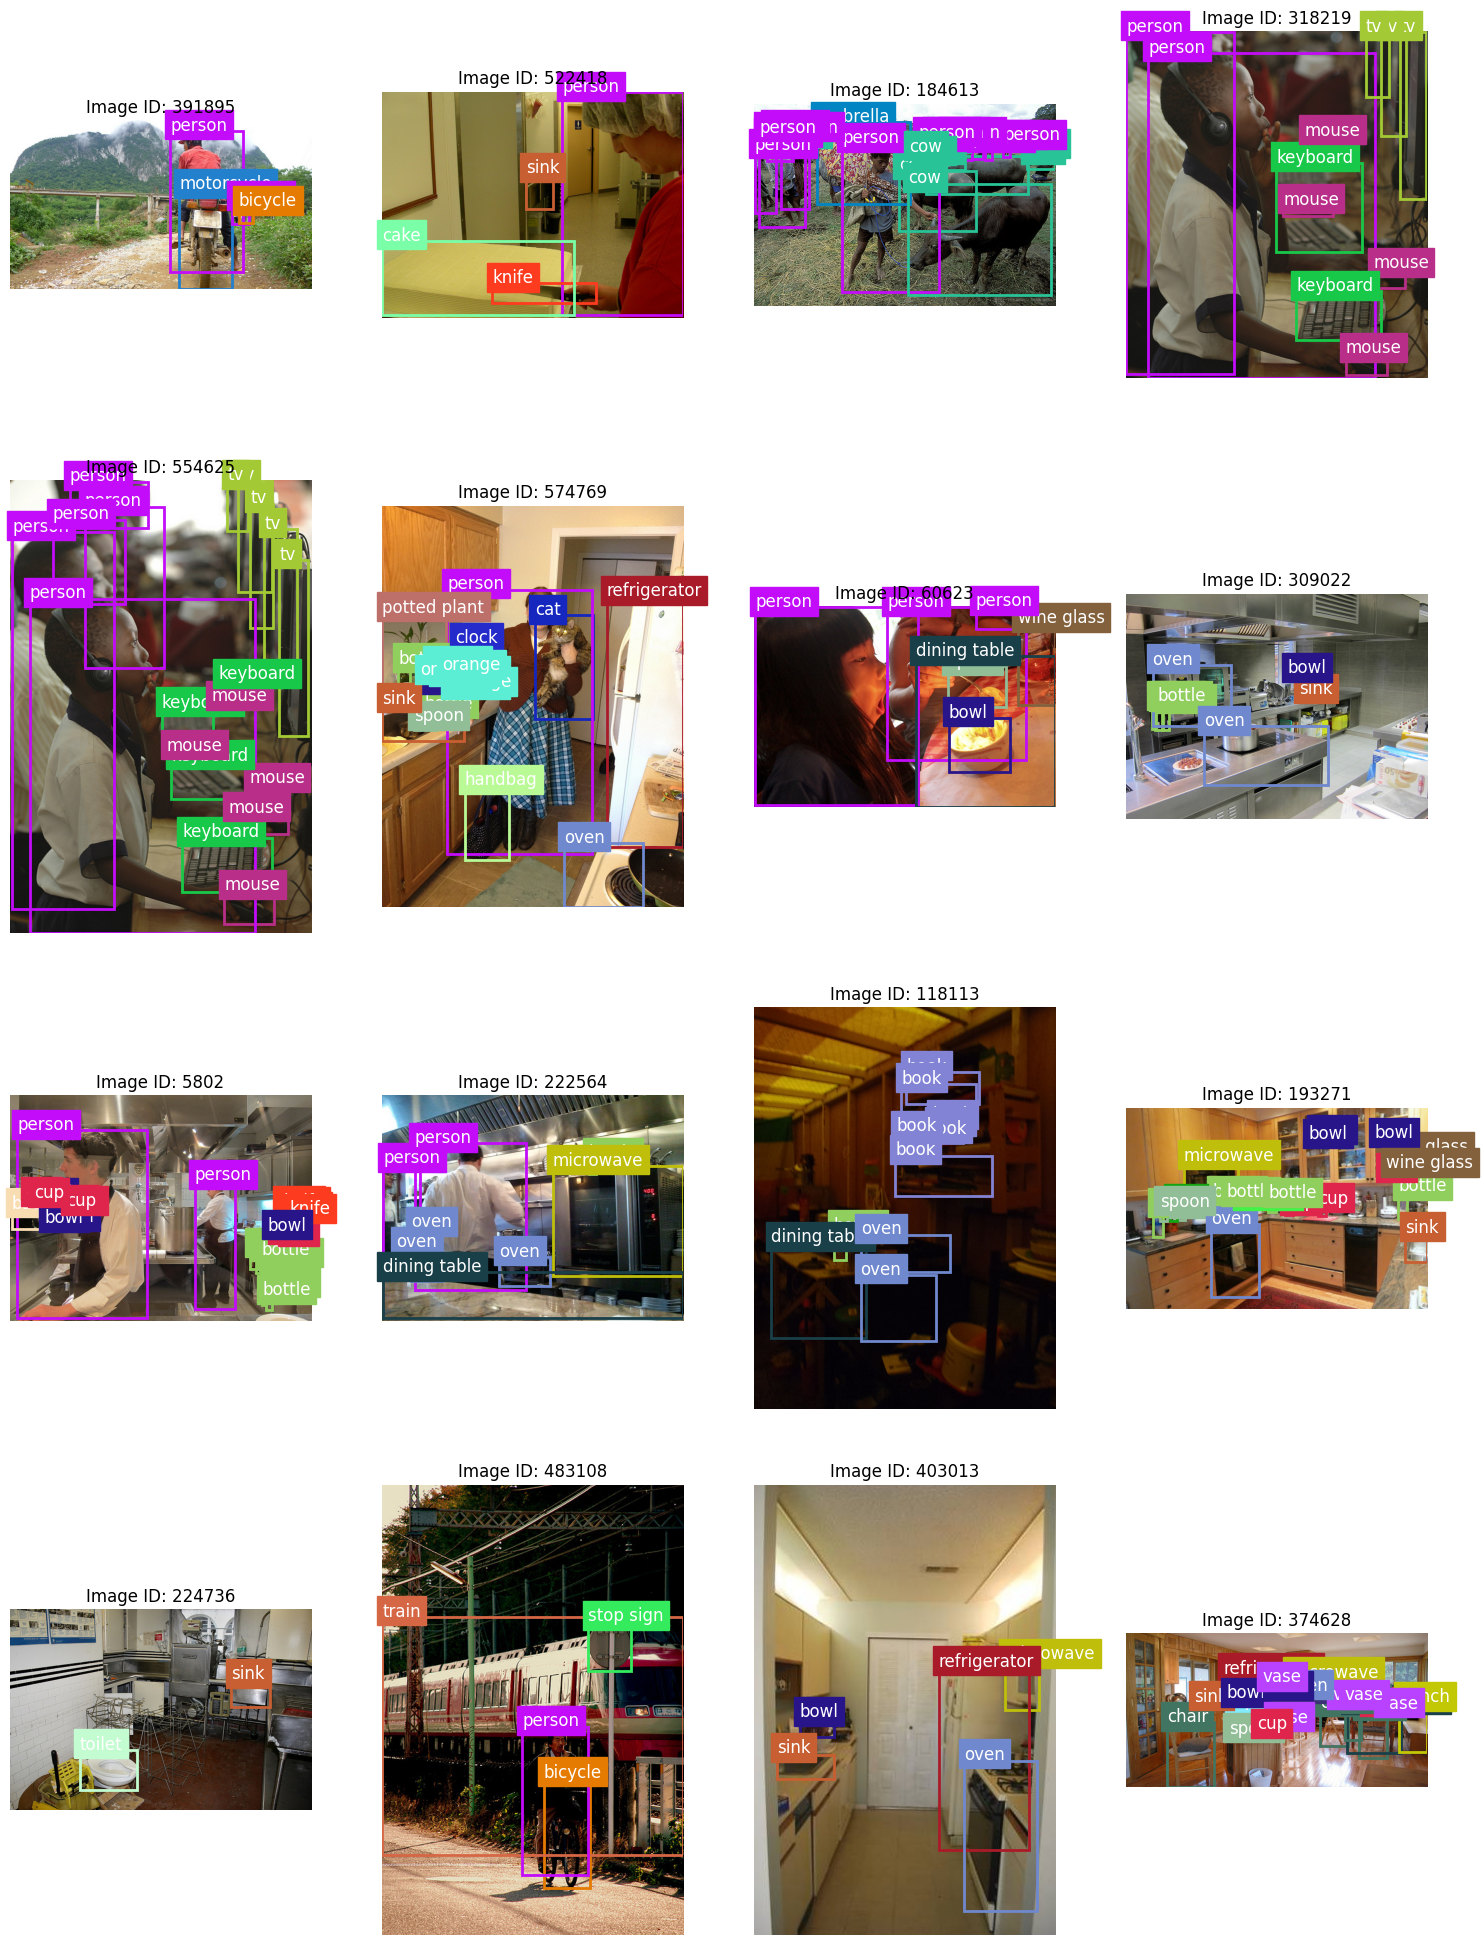

In [ ]:
display_images_with_annotations(images[:16], coco, num_cols=4)

In [ ]:
# 클래스 지정
cat_ids = coco.getCatIds(catNms=['person'])

# 이미지 불러오기
img_ids = coco.getImgIds(catIds=cat_ids)

# 이미지 정보 불러오기
images = coco.loadImgs(img_ids)
print(len(images))

64115


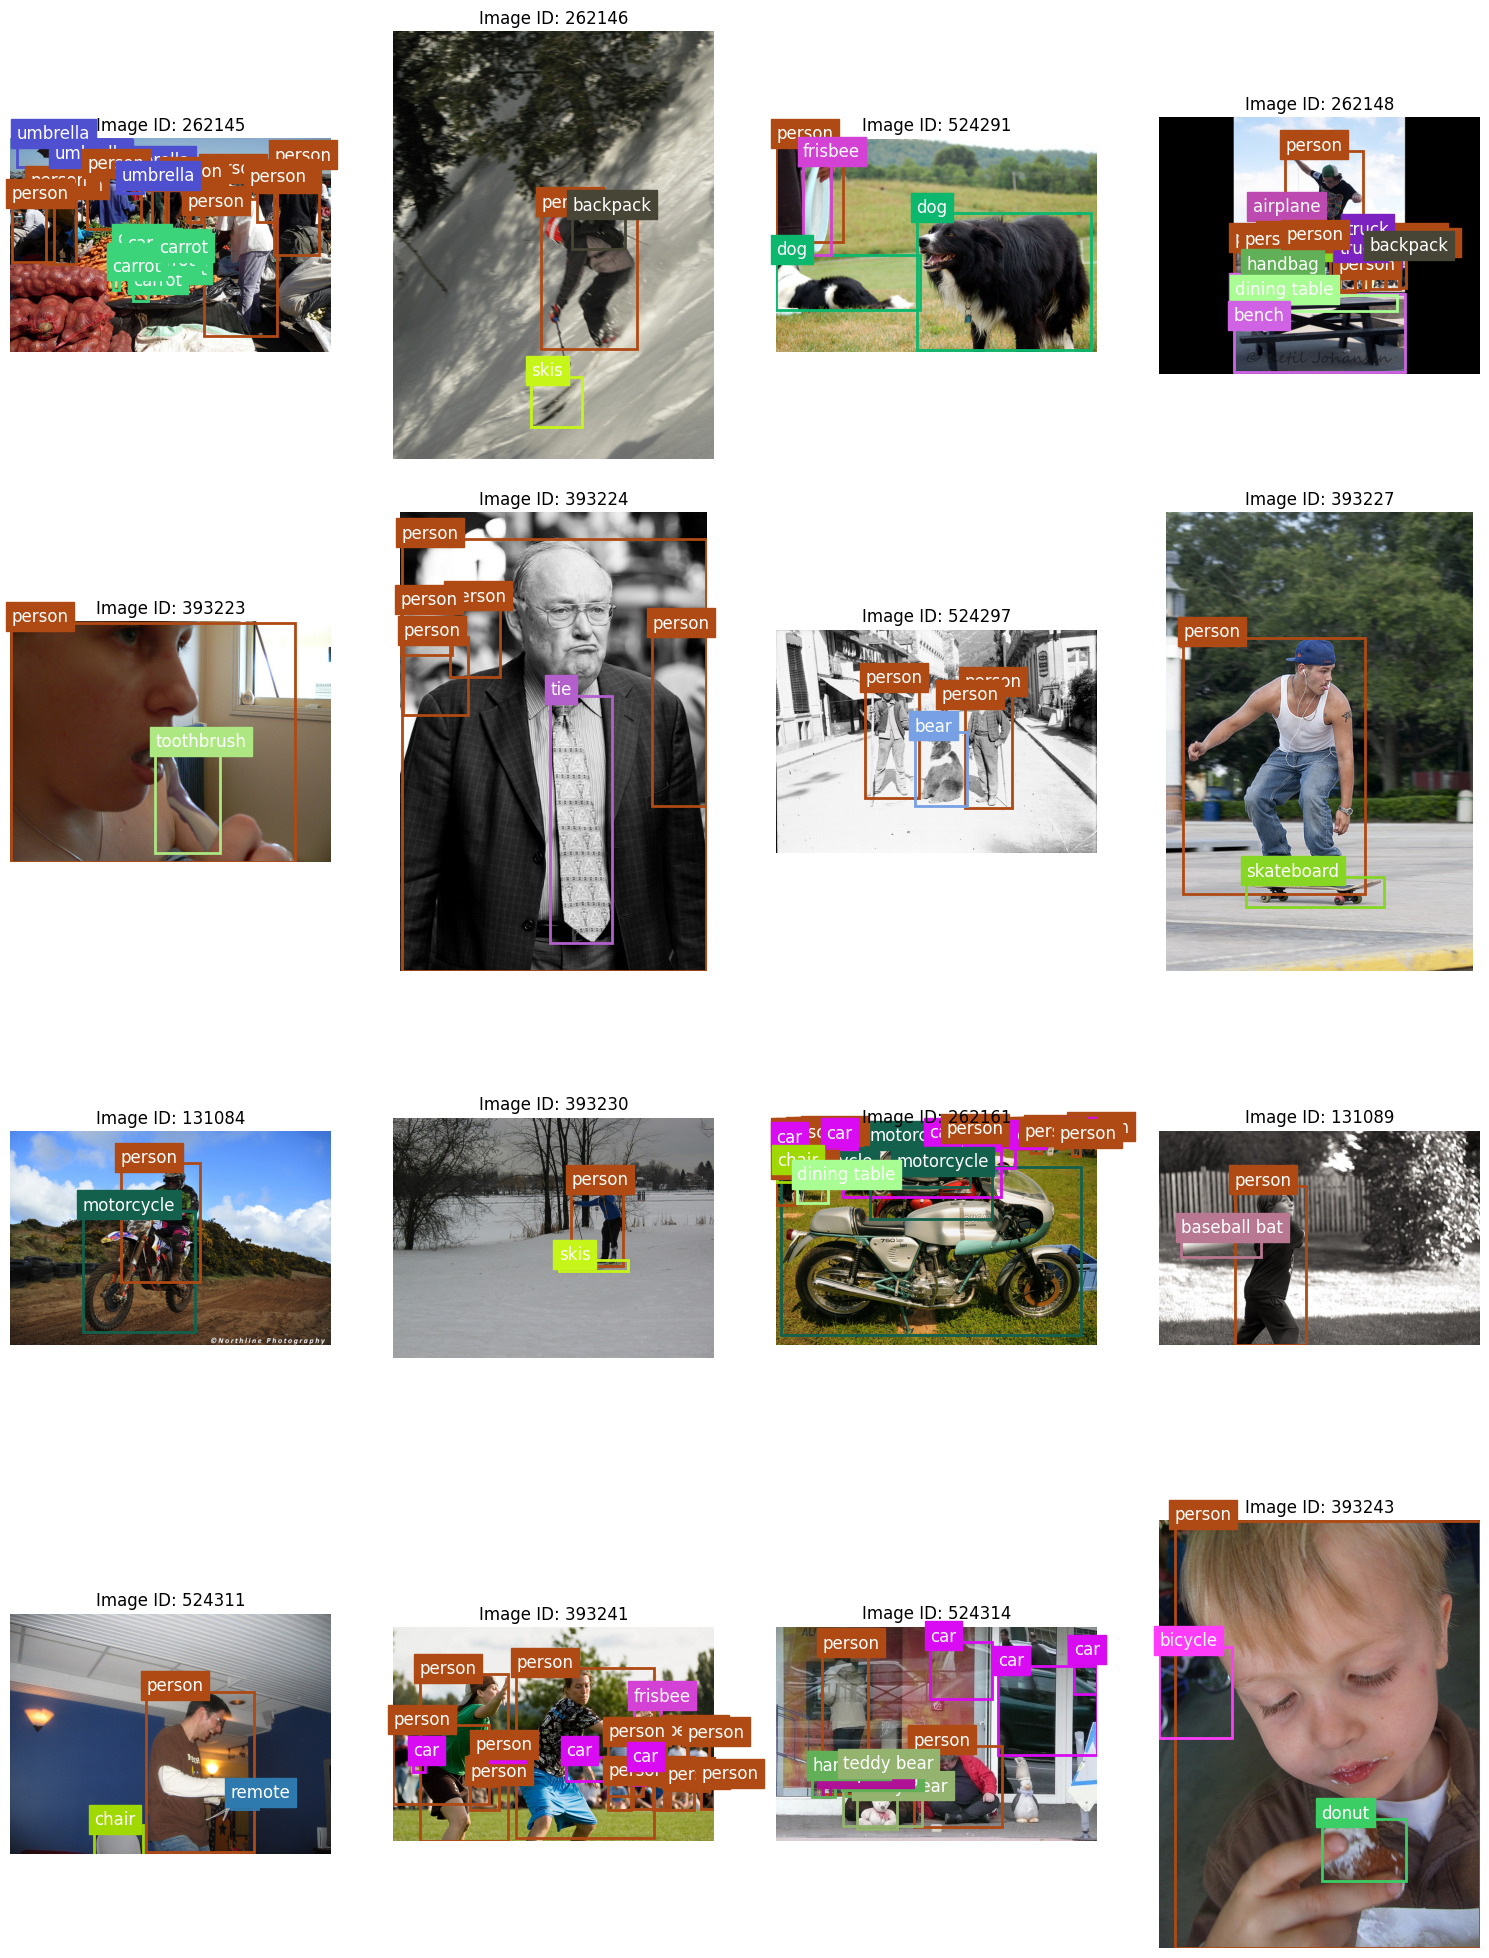

In [ ]:
display_images_with_annotations(images[:16], coco, num_cols=4)

In [ ]:
# 사람 이미지만 annotation 추가
def display_single_image_with_annotations(image, coco):
    img_path = os.path.join(imageDir, image['file_name'])
    img_data = Image.open(img_path)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img_data)

    ann_ids = coco.getAnnIds(imgIds=image['id'], catIds=cat_ids, iscrowd=False)
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        bbox = ann['bbox']
        category_id = ann['category_id']
        category_name = coco.loadCats(category_id)[0]['name']
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(bbox[0], bbox[1] - 2, category_name, fontsize=12, color='white', backgroundcolor='red')

    ax.axis('off')
    ax.set_title(f'Image ID: {image["id"]}')
    plt.show()

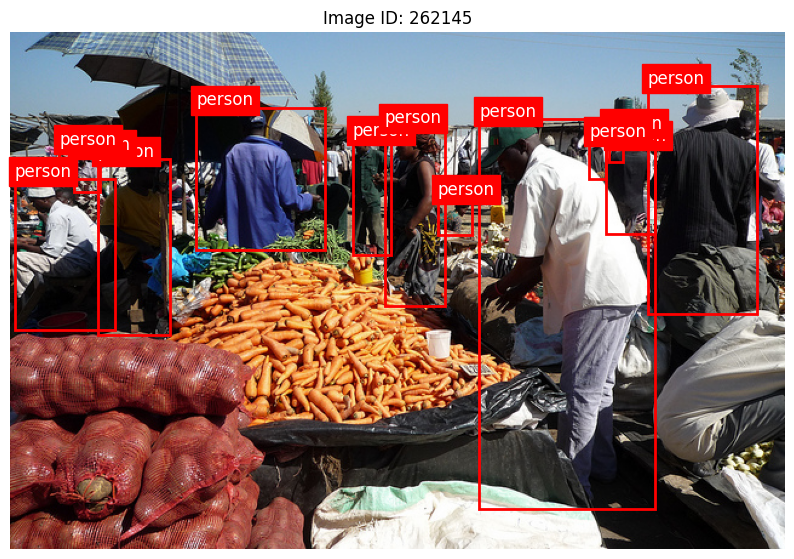

In [ ]:
display_single_image_with_annotations(images[0], coco)

In [ ]:
ANNOTATION_FILE_TRAIN = '/content/annotations/instances_train2017.json'
ANNOTATION_FILE_VAL = '/content/annotations/instances_val2017.json'

In [ ]:
# 클래스 지정
classes = ['person']

# train set의 API 초기화 및 카테고리 정보 로드
coco_train = COCO(ANNOTATION_FILE_TRAIN)
catIds_train = coco_train.getCatIds(catNms=classes)
imgIds_train = coco_train.getImgIds(catIds=catIds_train)
imgDict_train = coco_train.loadImgs(imgIds_train)

# val set의 API 초기화 및 카테고리 정보 로드
coco_val = COCO(ANNOTATION_FILE_VAL)
catIds_val = coco_val.getCatIds(catNms=classes)
imgIds_val = coco_val.getImgIds(catIds=catIds_val)
imgDict_val = coco_val.loadImgs(imgIds_val)

# 이미지 및 카테고리 수 출력
print(len(imgIds_train), len(catIds_train))
print(len(imgIds_val), len(catIds_val))

loading annotations into memory...
Done (t=32.57s)
creating index...
index created!
loading annotations into memory...
Done (t=1.21s)
creating index...
index created!
64115 1
2693 1


In [ ]:
# 이미지 ID 셔플
shuffle(imgIds_train)
shuffle(imgIds_val)

# 이미지 ID 서브셋 선택
imgIds_val = imgIds_val[0:600]
imgIds_train = imgIds_train[0:6000]

# 'person' 이미지 파일 이름 생성
train_images_person = ["train2017_{0:012d}.jpg".format(ids) for ids in imgIds_train]
val_images_person = ["val2017_{0:012d}.jpg".format(ids) for ids in imgIds_val]

# 'person' 이미지 파일 수 출력
print(len(train_images_person), len(val_images_person))

6000 600


In [ ]:
# train set의 'person' 이미지 파일 이름 목록 생성
train_images_person = ["train2017_{0:012d}.jpg".format(ids) for ids in imgIds_train]

# val set의 'person' 이미지 파일 이름 목록 생성
val_images_person = ["val2017_{0:012d}.jpg".format(ids) for ids in imgIds_val]

# 이미지 디렉토리 내 파일 수 확인
len(os.listdir("/content/val2017"))

5000

In [ ]:
# 생성할 훈련용 마스크를 저장할 디렉토리 생성
!mkdir mask_train2017

count = 0

# 훈련 이미지에 대한 마스크 생성
for ID in imgIds_train:

    file_path = "/content/mask_train2017/train2017_{0:012d}.jpg".format(ID)

    # 훈련 세트에서 무작위 이미지 ID 가져오기
    sampleImgIds = coco_train.getImgIds(imgIds=[ID])
    sampleImgDict = coco_train.loadImgs(sampleImgIds[np.random.randint(0, len(sampleImgIds))])[0]

    # 이미지에 대한 주석 ID 및 주석 가져오기
    annIds = coco_train.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_train, iscrowd=0)
    anns = coco_train.loadAnns(annIds)

    # 개별 인스턴스 마스크를 결합하여 마스크 생성
    mask = coco_train.annToMask(anns[0])
    for i in range(len(anns)):
      mask = mask | coco_train.annToMask(anns[i])

    # 마스크를 이미지로 변환하고 저장
    mask = Image.fromarray(mask * 255, mode="L")
    mask.save(file_path)
    count = count + 1

In [ ]:
# 생성할 검증용 마스크를 저장할 디렉토리 생성
!mkdir mask_val2017

count = 0

# 검증 이미지에 대한 마스크 생성
for ID in imgIds_val:

    file_path = "/content/mask_val2017/val2017_{0:012d}.jpg".format(ID)

    # 훈련 세트에서 무작위 이미지 ID 가져오기
    sampleImgIds = coco_val.getImgIds(imgIds=[ID])
    sampleImgDict = coco_val.loadImgs(sampleImgIds[np.random.randint(0, len(sampleImgIds))])[0]

    # 이미지에 대한 주석 ID 및 주석 가져오기
    annIds = coco_val.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_val, iscrowd=0)
    anns = coco_val.loadAnns(annIds)

    # 개별 인스턴스 마스크를 결합하여 마스크 생성
    mask = coco_val.annToMask(anns[0])
    for i in range(len(anns)):
        mask = mask | coco_val.annToMask(anns[i])

    # 마스크를 이미지로 변환하고 저장
    mask = Image.fromarray(mask * 255, mode="L")
    mask.save(file_path)

    count = count + 1

In [ ]:
class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, images_path, masks_path, batch_size):
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.image_filenames = self.get_matching_filenames()
        self.mask_filenames = self.get_matching_filenames()

    def get_matching_filenames(self):
        image_files = set([os.path.splitext(filename)[0] for filename in os.listdir(self.images_path)])
        mask_files = set([os.path.splitext(filename[len('train2017_'):])[0] for filename in os.listdir(self.masks_path)])
        matching_files = list(image_files.intersection(mask_files))
        return matching_files

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, idx):
        batch_filenames = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_images = []
        batch_masks = []

        for filename in batch_filenames:
            image_path = os.path.join(self.images_path, filename + '.jpg')
            mask_path = os.path.join(self.masks_path, 'train2017_' + filename + '.jpg')

            image = Image.open(image_path)
            mask = Image.open(mask_path)

            if image.size != mask.size:
                raise ValueError(f"Incompatible dimensions for image {image_path} and mask {mask_path}")

            image = image.resize((128, 128))
            mask = mask.resize((128, 128))

            preprocessed_image = np.array(image)
            preprocessed_mask = np.array(mask)

            if len(preprocessed_image.shape) == 3 and preprocessed_image.shape == (128, 128, 3):
                preprocessed_image = preprocessed_image / 255.0
                preprocessed_mask = preprocessed_mask / 255.0

                batch_images.append(preprocessed_image)
                batch_masks.append(preprocessed_mask)

        return np.array(batch_images), np.array(batch_masks)

In [ ]:
images_path = '/content/train2017'
masks_path = '/content/mask_train2017'
batch_size = 8

train_generator = CustomDataGenerator(images_path, masks_path, batch_size)
val_generator = CustomDataGenerator('/content/val2017', '/content/mask_val2017', batch_size)

In [ ]:
def validate_image_shapes(generator):
    for i in range(len(generator)):
        batch_images, _ = generator[i]

        for image in batch_images:
            print(f"Shape of preprocessed image: {image.shape}")

validate_image_shapes(train_generator)

Image ID: 000000117184.jpg
Mask Shape: (128, 128)
Main Image Shape: (128, 128, 3)


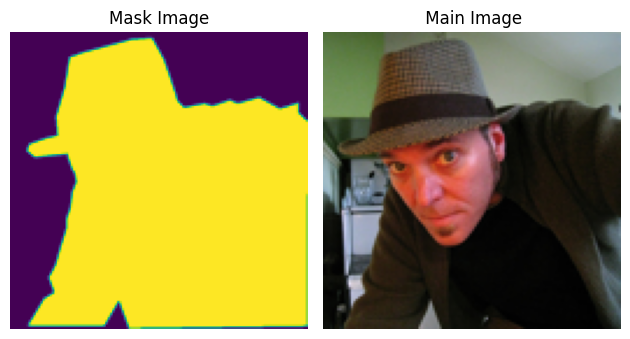

In [ ]:
batch_images, batch_masks = train_generator[0]

preprocessed_image = batch_images[0]
preprocessed_mask = batch_masks[0]

plt.subplot(1, 2, 1)
plt.imshow(preprocessed_mask)
plt.title('Mask Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image)
plt.title(' Main Image')
plt.axis('off')

print('Image ID:', train_generator.image_filenames[0]+'.jpg')
print('Mask Shape:', preprocessed_mask.shape)
print('Main Image Shape:', preprocessed_image.shape)

plt.tight_layout()
plt.show()

In [ ]:
original_image = train_generator.image_filenames[0] + '.jpg'
original_image_path = '/content/train2017/{}'.format(original_image)
image = Image.open(original_image_path)

print('Image ID:', train_generator.image_filenames[0] + '.jpg')
print('Main Image Shape:', image.size)

Image.open(original_image_path)

### 3. Data Analysis

In [ ]:
# U-Net 모델
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
# AdamW 옵티마이저 정의
optimizer = tfa.optimizers.AdamW(weight_decay=1e-4, learning_rate=1e-3)

# 모델 컴파일
model = unet_model()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 체크포인트 콜백 정의
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/데기인/checkpoint/AdamW_best_model(수정).h5',  
    monitor='val_accuracy',    
    save_best_only=True,     
    mode='max',                
    save_weights_only=True,    
    verbose=1 
)

# 모델 학습
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1,
    callbacks=[checkpoint_callback]
)

In [ ]:
model.save('/content/drive/MyDrive/데기인/checkpoint/AdamW_final_model.h5')

### 5. Result

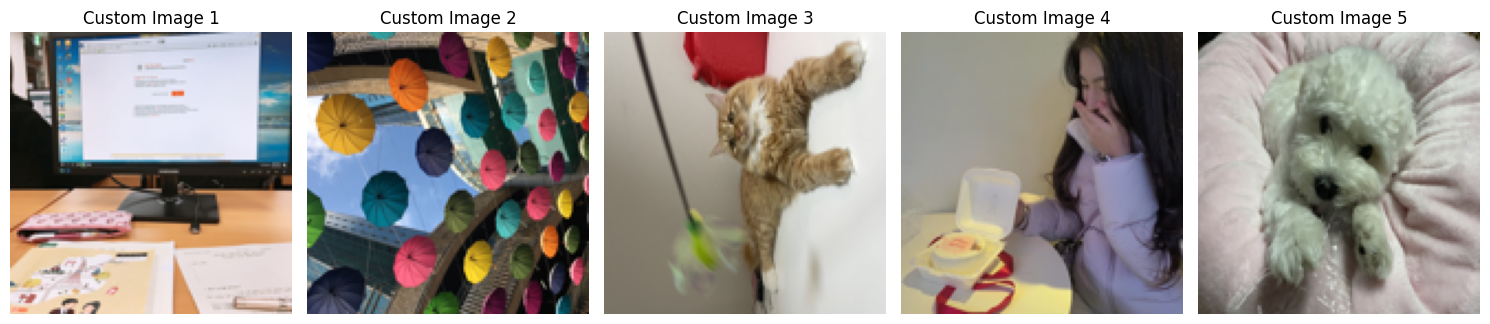

In [ ]:
# Custom 이미지 전처리
def process_custom_images(custom_image_paths):
    images = []
    for image_path in custom_image_paths:
        image = Image.open(image_path).convert('RGB')
        image = image.resize((128, 128))
        preprocessed_image = np.array(image) / 255.0
        images.append(preprocessed_image)
    return np.array(images)

# Custom 이미지 시각화
def visualize_predictions(images, predicted_masks):
    num_images = len(images)
    fig, axs = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

    for i in range(num_images):
        axs[i, 0].imshow(images[i])
        axs[i, 0].set_title(f'Input Image {i+1}')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(predicted_masks[i], cmap='gray')
        axs[i, 1].set_title(f'Predicted Mask {i+1}')
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

custom_images_path = '/content/my_images'
custom_image_names = ['custom_1.jpg', 'custom_2.jpg', 'custom_3.jpg', 'custom_4.jpg', 'custom_5.jpg']
custom_image_paths = [os.path.join(custom_images_path, name) for name in custom_image_names]

custom_images = process_custom_images(custom_image_paths)
predicted_masks = model.predict(custom_images)
predicted_masks = (predicted_masks * 255).astype(np.uint8)
visualize_predictions(custom_images, predicted_masks)